In [1]:
import numpy as np
import json
from collections import Counter
from matplotlib import pyplot as plt
import os
import pickle

In [2]:
def counter_to_array(counter, n_classes=10):
    array = np.zeros(n_classes, dtype=np.int64)
    for key, value in counter.items():
        array[key] += value
    return array

In [3]:
TASK = 'synthetic_classification_cnum10_dist10_skew0.5_seed0'

In [4]:
with open('/mnt/disk1/duongtn/ShapleyFL/fedtask/{}/data.json'.format(TASK), 'r') as f:
    data= json.load(f)

In [5]:
data.keys()

dict_keys(['store', 'client_names', 'dtest', 'Client00', 'Client01', 'Client02', 'Client03', 'Client04', 'Client05', 'Client06', 'Client07', 'Client08', 'Client09'])

In [6]:
print('test', len(data['dtest']['y']))
for client in data['client_names']:
    print(client, len(data[client]['dtrain']['y']), len(data[client]['dvalid']['y']))

test 1433
Client00 590 127
Client01 569 122
Client02 568 122
Client03 896 192
Client04 562 120
Client05 696 149
Client06 816 175
Client07 805 173
Client08 595 128
Client09 562 121


In [7]:
counter = Counter(data['dtest']['y'])
print('test', counter_to_array(counter))
for client in data['client_names']:
    counter = Counter(data[client]['dtrain']['y'])
    print(client, counter_to_array(counter))

test [122 283 475  33 151  52  86 124 107   0]
Client00 [116   0 462   0   0   0  12   0   0   0]
Client01 [  0   0   0   0 548   0   7  14   0   0]
Client02 [  0   0   1   0   0 216   0 351   0   0]
Client03 [  0   0 896   0   0   0   0   0   0   0]
Client04 [  0 364   0 183   0   0  15   0   0   0]
Client05 [  0   0 696   0   0   0   0   0   0   0]
Client06 [  1 185 127   0   0   0   0   0 503   0]
Client07 [  0 691   0   1 113   0   0   0   0   0]
Client08 [425   0   0   0   0   0   0 170   0   0]
Client09 [  0  53   8   0  17   0 387  97   0   0]


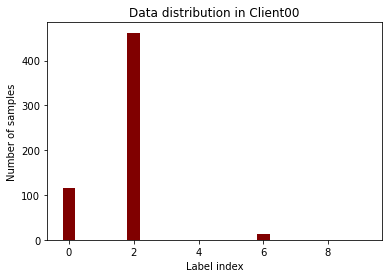

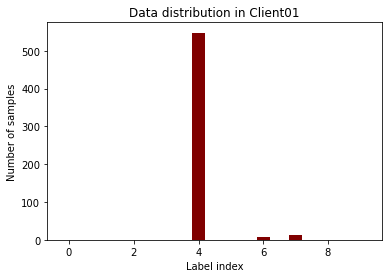

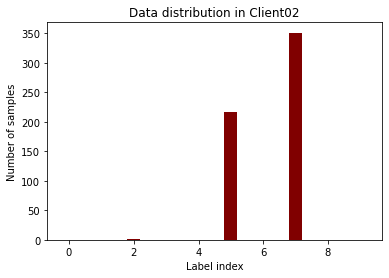

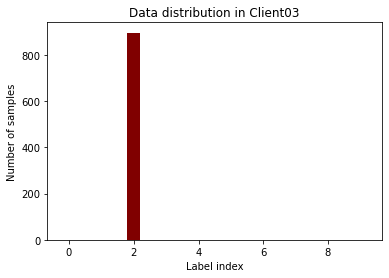

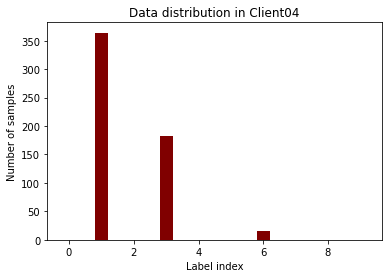

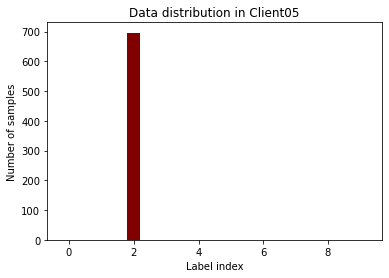

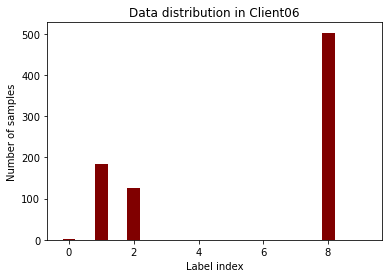

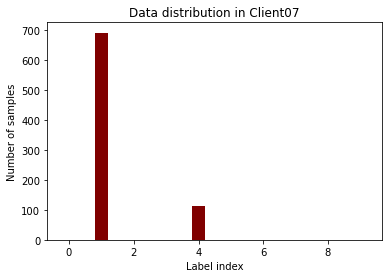

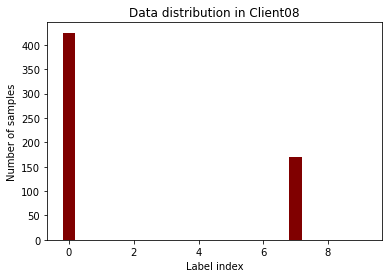

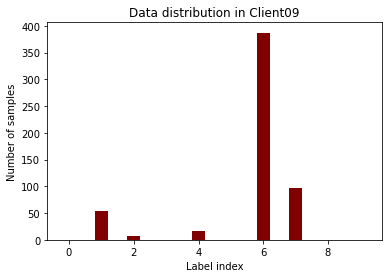

In [8]:
label = [i for i in range(10)]
for client in data['client_names']:
    counter = Counter(data[client]['dtrain']['y'])
    number_of_samples = counter_to_array(counter)
    plt.bar(label, number_of_samples, color='maroon', width=0.4)
    plt.xlabel("Label index")
    plt.ylabel("Number of samples")
    plt.title(f"Data distribution in {client}")
    plt.show()
    

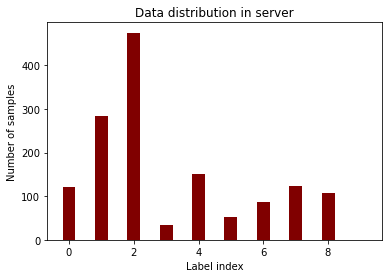

In [9]:
counter = Counter(data['dtest']['y'])
number_of_samples = counter_to_array(counter)
plt.bar(label, number_of_samples, color='maroon', width=0.4)
plt.xlabel("Label index")
plt.ylabel("Number of samples")
plt.title(f"Data distribution in server")
plt.show()

In [10]:
train_len = np.array([len(data[client]['dtrain']['y']) for client in data['client_names']])
train_len_p = train_len / train_len.sum()
train_len_p

array([0.08860189, 0.08544827, 0.08529809, 0.13455474, 0.08439706,
       0.1045202 , 0.12254092, 0.12088902, 0.08935276, 0.08439706])

In [11]:
train_len.sum()

6659

In [12]:
folder = 'fedtask/{}/record/'.format(TASK)
prefix = 'fedavg_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
DICT = dict()
files = os.listdir(folder)
files.sort(reverse=True)
for file in files:
    if file.startswith(prefix):
        with open(os.path.join(folder, file), 'r') as f:
            DICT[file.replace(prefix, '').replace('.json', '')] = np.array(json.load(f)['test_accuracy'])
DICT['0' * len(data['client_names'])] = np.zeros(101)

In [13]:
folder = 'fedtask/{}/record/'.format(TASK)
prefix = 'fedavg_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
LOSS_DICT = dict()
files = os.listdir(folder)
files.sort(reverse=False)
for file in files:
    if file.startswith(prefix):
        with open(os.path.join(folder, file), 'r') as f:
            LOSS_DICT[file.replace(prefix, '').replace('.json', '')] = np.array(json.load(f)['test_loss'])

# LOSS_DICT['0' * len(data['client_names'])] = np.zeros(101)

In [14]:
# plt.figure(figsize=(15, 10))
# for key, value in DICT.items():
#     plt.plot(value[:], label=key)
# plt.legend()
# plt.show()

In [15]:
from bitsets import bitset
import itertools

In [16]:
CLIENTS_BITSET = bitset('clients_bitset', tuple(data['client_names']))

In [17]:
# # calculate ideal sv 100 rounds
# SV = dict()
# for client in data['client_names']:
#     result = 0.0
#     rest_clients = [client_ for client_ in data['client_names'] if client_ != client]
#     for i in range(0, len(rest_clients) + 1):
#         a_i = 0.0
#         count_i = 0
#         for subset in itertools.combinations(rest_clients, i):
#             # print(subset)
#             a_i += DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
#                 DICT[CLIENTS_BITSET(subset).bits()].max()
#             if DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
#                 DICT[CLIENTS_BITSET(subset).bits()].max() < 0:
#                     print(client, subset)
#             # print(DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1], DICT[CLIENTS_BITSET(subset).bits()][-1])
#             count_i += 1
#         # print(a_i, count_i)
#         a_i = a_i / count_i
#         result += a_i
#     result = result / len(data['client_names'])
#     SV[client] = result

In [18]:
#calculate ideal SV per round
SV = dict()
for round_ in range(1, 101):
    SV[round_] = dict()
    for client in data['client_names']:
        result = 0.0
        rest_clients = [client_ for client_ in data['client_names'] if client_ != client]
        for i in range(0, len(rest_clients) + 1):
            a_i = 0.0
            count_i = 0
            for subset in itertools.combinations(rest_clients, i):
                # print(subset)
                a_i += DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][:round_ + 1].max() - \
                    DICT[CLIENTS_BITSET(subset).bits()][:round_ + 1].max()
                # if DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                #     DICT[CLIENTS_BITSET(subset).bits()].max() < 0:
                #         print(client, subset)
                # print(DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1], DICT[CLIENTS_BITSET(subset).bits()][-1])
                count_i += 1
            # print(a_i, count_i)
            a_i = a_i / count_i
            result += a_i
        result = result / len(data['client_names'])
        SV[round_][client] = result

In [19]:
def scale_to_one(data_list):
    data_list = np.array(data_list)
    return data_list / data_list.sum()

In [20]:
label = [i for i in range(10)]
sample_size = []
for client in data['client_names']:
    sample_size.append(len(data[client]['dtrain']['y']))

sample_size = np.array(sample_size)
sample_size = sample_size / sample_size.sum()

In [28]:
def get_end_round(bitset_, esp_):
    K = 10
    if bitset_ == '0' * len(data['client_names']):
        return 0.0
    end_round = 0
    for end_round in range(1, 101):
        if LOSS_DICT[bitset_][max(end_round - K + 1, 0):end_round + 1].var() < esp_:
            break
    return end_round

In [29]:
def uf(bitset_, esp_):
    end_round = int(get_end_round(bitset_, esp_))
    return DICT[bitset_][:end_round + 1].max()

In [30]:
for i in range(1, len(data['client_names']) + 1):
    for subset in itertools.combinations(data['client_names'], i):
        uf(CLIENTS_BITSET(subset).bits(), 1e-6)
    #     break
    # break

In [31]:
# calculate ideal sv 100 rounds
SV_TEMP = dict()
for esp in [1e-4, 1e-5, 2e-5, 3e-5, 4e-5]:
    SV_TEMP[esp] = dict()
    for client in data['client_names']:
        result = 0.0
        rest_clients = [client_ for client_ in data['client_names'] if client_ != client]
        for i in range(0, len(rest_clients) + 1):
            a_i = 0.0
            count_i = 0
            for subset in itertools.combinations(rest_clients, i):
                # print(subset)
                # a_i += DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                #     DICT[CLIENTS_BITSET(subset).bits()].max()
                a_i += uf(CLIENTS_BITSET(set(subset).union({client})).bits(), esp) - uf(CLIENTS_BITSET(subset).bits(), esp)
                # if DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                #     DICT[CLIENTS_BITSET(subset).bits()].max() < 0:
                #         print(client, subset)
                # print(DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1], DICT[CLIENTS_BITSET(subset).bits()][-1])
                count_i += 1
            # print(a_i, count_i)
            a_i = a_i / count_i
            result += a_i
        result = result / len(data['client_names'])
        SV_TEMP[esp][client] = result

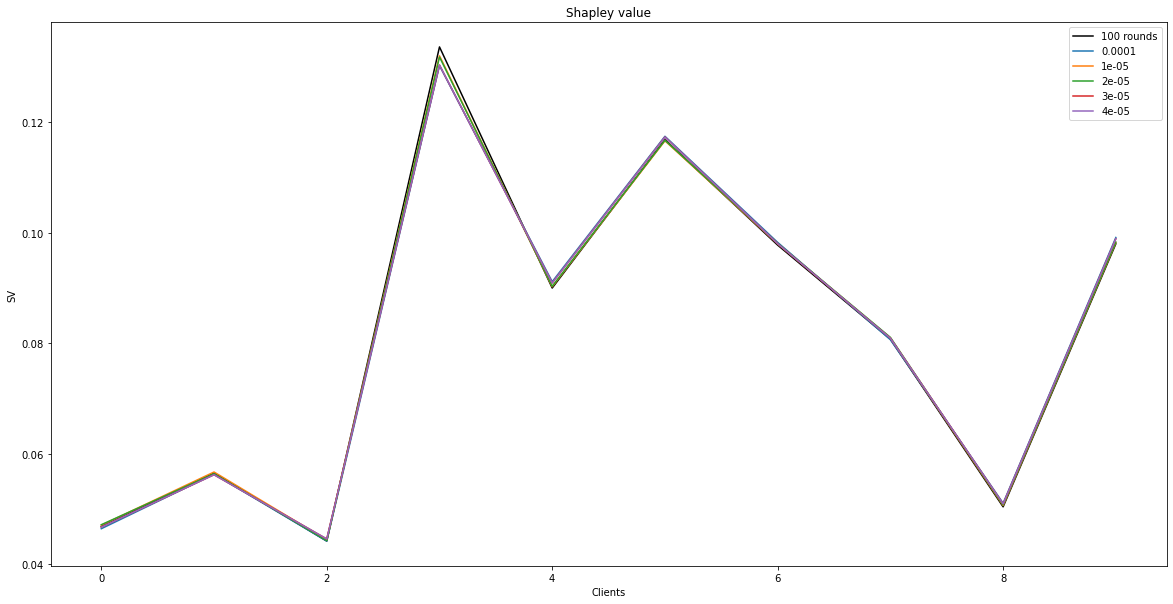

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(list(SV[100].values()), label='100 rounds', color='black')
for key, value in SV_TEMP.items():
    plt.plot(list(value.values()), label=key)
# plt.plot(sample_size, color='blue')
plt.xlabel("Clients")
plt.ylabel("SV")
plt.title(f"Shapley value")
plt.legend()
plt.show()

In [34]:
exact = list()
const_lambda = list()
optimal_lambda = dict()
for round_ in range(1, 101):
    # with open('SV_result/{}/min_max/minRound{}.npy'.format(TASK, round_), 'rb') as f:
    #     min_v = pickle.load(f)
    min_v = 0.0
    # with open('SV_result/{}/min_max/maxRound{}.npy'.format(TASK, round_), 'rb') as f:
    #     max_v = pickle.load(f)
    max_v = 1.0
    with open('SV_result/{}/exact-10/Round{}.npy'.format(TASK, round_), 'rb') as f:
        exact.append((pickle.load(f) / (max_v - min_v)).tolist())
    with open('SV_result/{}/const_lambda-10/Round{}.npy'.format(TASK, round_), 'rb') as f:
        const_lambda.append((pickle.load(f) / (max_v - min_v)).tolist())
    for ns in [30, 100, 300]:
        if ns not in optimal_lambda.keys():
            optimal_lambda[ns] = list()
        with open('SV_result/{}/optimal_lambda-10-{}/Round{}.npy'.format(TASK, ns, round_), 'rb') as f:
            optimal_lambda[ns].append((pickle.load(f) / (max_v - min_v)).tolist())
exact = np.array(exact)
const_lambda = np.array(const_lambda)
for key in optimal_lambda.keys():
    optimal_lambda[key] = np.array(optimal_lambda[key])
exact.shape, const_lambda.shape, *[opt.shape for opt in optimal_lambda.values()]

((100, 10), (100, 10), (100, 10), (100, 10), (100, 10))

In [71]:
const_lambda[0], optimal_lambda[100][0]

(array([0.0434636 , 0.02555245, 0.02944871, 0.10865318, 0.09620842,
        0.11237497, 0.10929286, 0.06387532, 0.05009304, 0.07911142]),
 array([0.03420857, 0.02035501, 0.02345876, 0.08551685, 0.07663935,
        0.08844614, 0.08602032, 0.0508829 , 0.03990398, 0.06226564]))

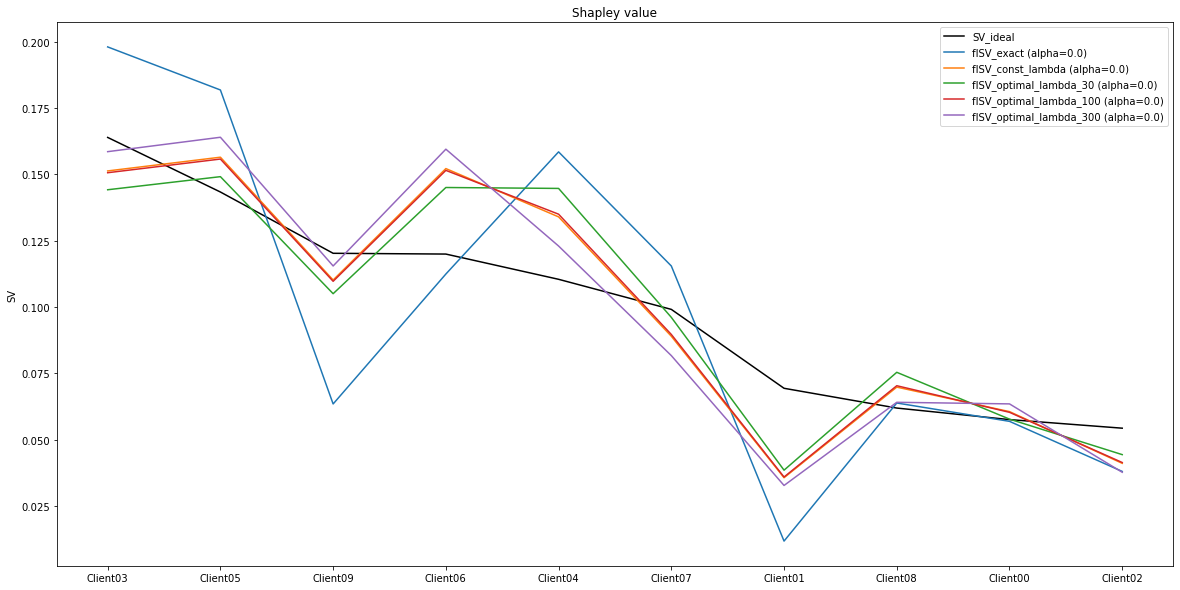

In [70]:
ideal = scale_to_one(list(SV[100].values()))
alphas = np.arange(0.0, 1.0 + 1e-3, 0.01)
tmp = list()
for alpha in alphas:
    c = np.zeros(10)
    for j, e in enumerate(exact):
        c = c + e * (alpha ** j)
    tmp.append(np.corrcoef(ideal, scale_to_one(c))[0, 1])
tmp = np.array(tmp)
alpha = alphas[tmp.argmax()]
plt.figure(figsize=(20, 10))
ideal = scale_to_one(list(SV[100].values()))
client_names = np.array(data['client_names'])
plt.plot(client_names[np.argsort(ideal)[::-1]], ideal[np.argsort(ideal)[::-1]], label='SV_ideal', color='black')

d = np.zeros(10)
if alpha == 0.0:
    d = exact[0]
else:
    for j, e in enumerate(exact[:]):
        d = d + e * (alpha ** j)
plt.plot(scale_to_one(d)[np.argsort(ideal)[::-1]], label='flSV_exact (alpha={})'.format(alpha))
d = np.zeros(10)
if alpha == 0.0:
    d = const_lambda[0]
else:
    for j, e in enumerate(const_lambda[:]):
        d = d + e * (alpha ** j)
plt.plot(scale_to_one(d)[np.argsort(ideal)[::-1]], label='flSV_const_lambda (alpha={})'.format(alpha))
for key, value in optimal_lambda.items():
    d = np.zeros(10)
    if alpha == 0.0:
        d = value[0]
    else:
        for j, e in enumerate(value[:]):
            d = d + e * (alpha ** j)
    plt.plot(scale_to_one(d)[np.argsort(ideal)[::-1]], label='flSV_optimal_lambda_{} (alpha={})'.format(key, alpha))
# plt.xlabel("Clients")
plt.ylabel("SV")
plt.title(f"Shapley value")
plt.legend()
plt.show()

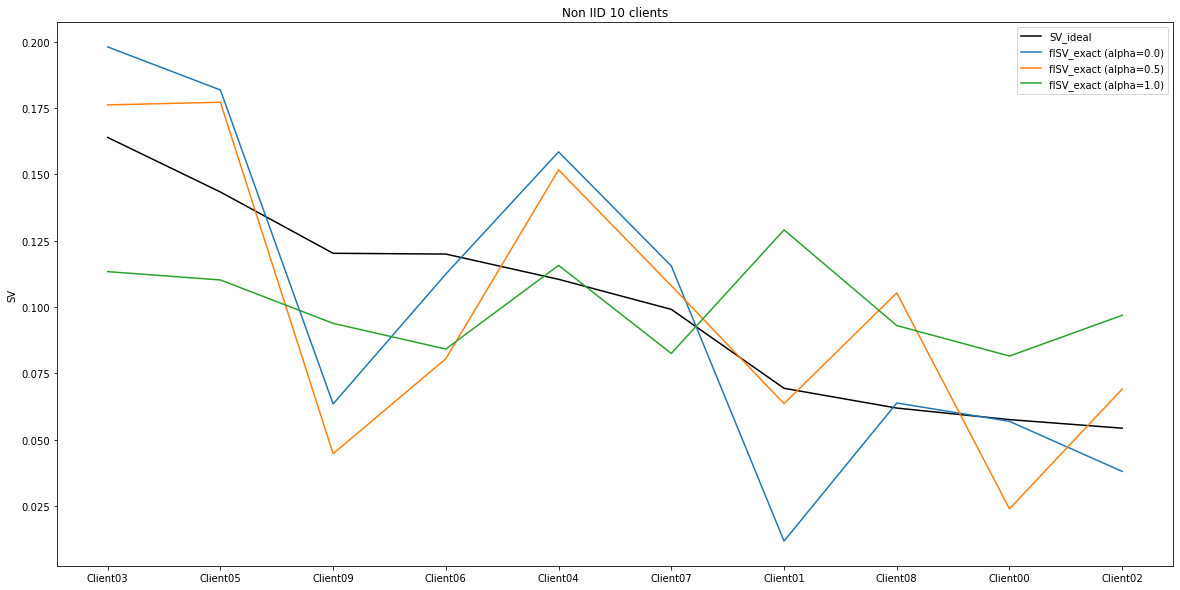

In [73]:
plt.figure(figsize=(20, 10))
ideal = scale_to_one(list(SV[100].values()))
client_names = np.array(data['client_names'])
plt.plot(client_names[np.argsort(ideal)[::-1]], ideal[np.argsort(ideal)[::-1]], label='SV_ideal', color='black')
alpha = 0.0
d = np.zeros(10)
if alpha == 0.0:
    d = exact[0]
else:
    for j, e in enumerate(exact[:]):
        d = d + e * (alpha ** j)
plt.plot(scale_to_one(d)[np.argsort(ideal)[::-1]], label='flSV_exact (alpha={})'.format(alpha))
alpha = 0.5
d = np.zeros(10)
if alpha == 0.0:
    d = exact[0]
else:
    for j, e in enumerate(exact[:]):
        d = d + e * (alpha ** j)
plt.plot(scale_to_one(d)[np.argsort(ideal)[::-1]], label='flSV_exact (alpha={})'.format(alpha))
alpha = 1.0
d = np.zeros(10)
if alpha == 0.0:
    d = exact[0]
else:
    for j, e in enumerate(exact[:]):
        d = d + e * (alpha ** j)
plt.plot(scale_to_one(d)[np.argsort(ideal)[::-1]], label='flSV_exact (alpha={})'.format(alpha))
plt.ylabel("SV")
plt.title(f"Non IID 10 clients")
plt.legend()
plt.show()

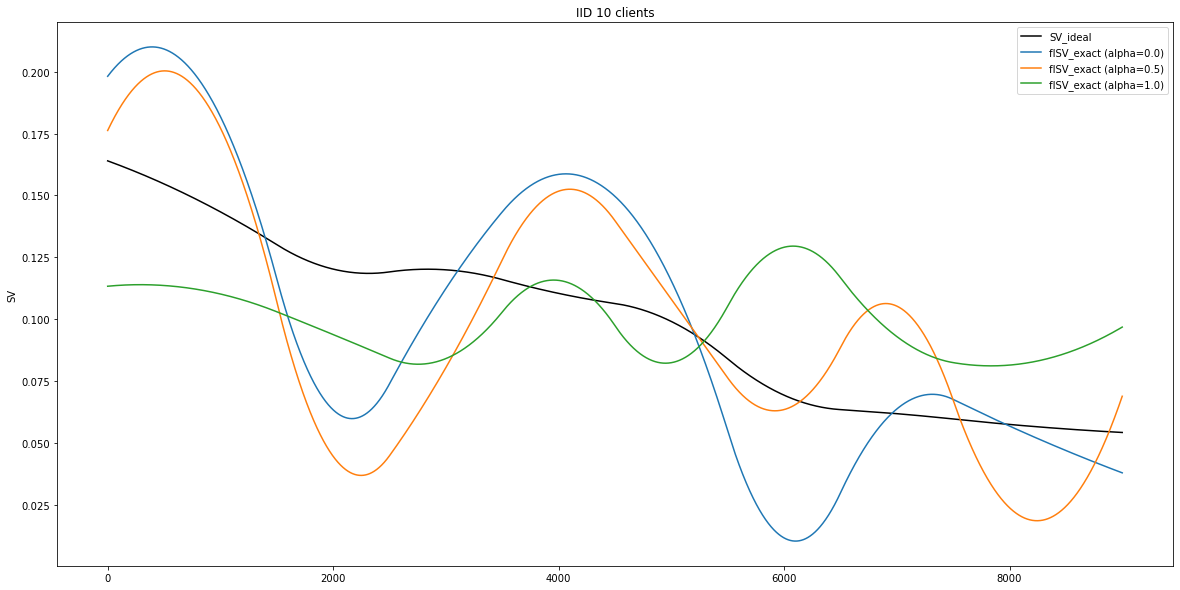

In [77]:
plt.figure(figsize=(20, 10))
x = np.arange(0, 10)
xnew = np.arange(0, 9, 0.001)
ideal = scale_to_one(list(SV[100].values()))
client_names = np.array(data['client_names'])
f = interpolate.interp1d(x, ideal[np.argsort(ideal)[::-1]], kind='quadratic')
ynew = f(xnew)
plt.plot(ynew, label='SV_ideal', color='black')
alpha = 0.0
d = np.zeros(10)
if alpha == 0.0:
    d = exact[0]
else:
    for j, e in enumerate(exact[:]):
        d = d + e * (alpha ** j)
f = interpolate.interp1d(x, scale_to_one(d)[np.argsort(ideal)[::-1]], kind='quadratic')
ynew = f(xnew)
plt.plot(ynew, label='flSV_exact (alpha={})'.format(alpha))
alpha = 0.5
d = np.zeros(10)
if alpha == 0.0:
    d = exact[0]
else:
    for j, e in enumerate(exact[:]):
        d = d + e * (alpha ** j)
f = interpolate.interp1d(x, scale_to_one(d)[np.argsort(ideal)[::-1]], kind='quadratic')
ynew = f(xnew)
plt.plot(ynew, label='flSV_exact (alpha={})'.format(alpha))
alpha = 1.0
d = np.zeros(10)
if alpha == 0.0:
    d = exact[0]
else:
    for j, e in enumerate(exact[:]):
        d = d + e * (alpha ** j)
f = interpolate.interp1d(x, scale_to_one(d)[np.argsort(ideal)[::-1]], kind='quadratic')
ynew = f(xnew)
plt.plot(ynew, label='flSV_exact (alpha={})'.format(alpha))
plt.ylabel("SV")
plt.title(f"IID 10 clients")
plt.legend()
plt.show()